# Overview

This report provides a comprehensive analysis of synthetic datasets representing equilibrium drift and excursion conditions. It covers data pre-processing, dataset generation, visualization, and preparation for machine learning modeling.
### I. Importing Libraries
Importing python libraries for analyzing and processing the data

### II. Data Pre-Processing

Cleaned dataset by removing commas from numeric values, converting columns to numeric types, and dropping non-essential columns (opt_mean, opt_sig).

### III. Dataset Overview

The dataset includes two scenarios:

- Drift: Stable operation with normally distributed variations.
- Excursion: Extreme drift with skewed dispersion, simulating real-world sensor behavior. Eight core variables were supplemented by eleven additional drift-specific variables for impact assessment.

### IV. Synthetic Data Generation
Generated 5,000 data points per variable using normal distributions. Applied skewed distributions for `x4`, `x5`, `x8`, and `x9` in the excursion dataset.

### V. Outcome Calculation
Computed a physics-based outcome vector, with an added interaction term for extreme conditions in the excursion dataset.

### VI. Data Visualization
- Density Plots: Compared variable distributions across datasets, confirming skew in excursion conditions.
- Outcome Distribution: Visualized drift progression in excursion data.
- Correlation Heatmap: Highlighted feature relationships in drift data.
- Interaction Heatmap: Explored the joint impact of x5 and x9 on the outcome

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Data Pre-Processing

In this section, we preprocess the dataset to ensure it is clean and ready for further analysis. One key task is removing all commas `,` from numeric values using regular expressions. This step is crucial because the presence of commas can lead to incorrect parsing and misinterpretation of the dataset.

To achieve this, we define the `safe_convert` function, which removes commas and converts the values into numeric format while coercing invalid entries to **NaN**.



In [2]:
# Function to remove commas and convert to numeric
def safe_convert(col):
    col_cleaned = col.replace(',', '', regex=True)
    return pd.to_numeric(col_cleaned, errors='coerce')

Next, we read the dataset and apply the transformation:

In [3]:
# Reading dataset and applying transformations
setpt = pd.read_csv('setpoint_publish(in).csv')

# Dropping unnecessary columns related to 'opt'
setpt.drop(columns=['opt_mean', 'opt_sig'], axis = 1, inplace=True)

# Applying the conversion function to all columns except 'var'
setpt = setpt.apply(lambda col: safe_convert(col) if col.name != 'var' else col)
setpt

,var,drift_mean,drift_sig,excursion_mean,excursion_sig
0,x1,22.111,0.442,22.115,0.5900
1,x2,46.010,1.840,46.547,2.3270
2,x4,0.368,0.027,0.304,0.0670
3,x5,135000.000,9000.000,120000.000,16000.0000
4,x7,1266.300,75.978,1266.300,88.6410
5,x8,91.176,6.686,107.880,12.2264
6,x9,456.270,22.814,599.280,69.9160
7,x17,5526.050,349.983,5552.410,425.6850
8,x3,39.000,2.860,NaN,NaN
9,x6,112.000,6.720,NaN,NaN


# 3. Dataset Overview
The dataset comprises two distinct scenarios: Drift and Excursion, each representing different operational conditions.

### 3.1 Drift Scenario
- Simulates stable long-term operation.
- Some variables exhibit drift, but the distribution remains normal.
- This scenario includes both core and additional variables.

### 3.2 Excursion Scenario
- Represents extreme drift where some variables deviate further.
- In these extreme conditions, the dispersion becomes skewed for certain sensors.
- This behavior mimics real-world component degradation.


<u>The dataset includes:</u>

1. **Mean** and **Standard Deviation** (S.D.) for each variable under both scenarios.
2. **8 core** variables and **11 additional** variables, which are non-physics-based but included for analysis.
3. **NaN** values for the additional variables in the excursion dataset, as they are only relevant for the drift scenario.


# 4. Synthetic Data Generation

### Function to generate normal and skewed normal data

To simulate realistic conditions, we generate synthetic data points based on the provided mean and dispersion values. We create **5000 data points** per variable. Since the excursion dataset contains skewed variables, we define two helper functions:

In [4]:
# Function to generate normal data
def generate_normal_data(mean, std_dev, size=5000, seed=42):
    return np.random.normal(loc=mean, scale=std_dev, size=size)

# Function to generate skewed normal data
def generate_skewed_normal_data(mean, std_dev, skew, size=5000, seed=42):
    return skewnorm.rvs(skew, loc=mean, scale=std_dev, size=size)

We generate synthetic datasets for both the drift and excursion scenarios and store them in a dictionary for further use.

In [5]:
datasets = {} # dict to store the generated number

# skewed variables parameters
skew_variables = {
    "x4": 200,
    "x5": 200,
    "x8": -100,
    "x9": -200
}

for data_name in ["drift", "excursion"]:
    rows = []
    for var, mean, sig in zip(setpt['var'], setpt[f'{data_name}_mean'], setpt[f'{data_name}_sig']):
        if data_name == "excursion" and var in skew_variables:
            # Generate skewed data for the specified variables (x4, x5, x8, x9)
            skew = skew_variables[var]
            rows.append(generate_skewed_normal_data(mean=mean, std_dev=sig, skew=skew, size=5000, seed=42))
        else:
            # Generate normal data for other variables
            rows.append(generate_normal_data(mean=mean, std_dev=sig, size=5000, seed=42))

    # Assign the generated data to the dataset
    datasets[data_name] = pd.DataFrame(np.column_stack(rows), columns=setpt['var'])

After generating synthetic data, we assign them to respective datasets:

- **Drift Dataset**: Contains all core and additional variables.
- **Excursion Dataset**: Excludes the additional variables, resulting in NaN values for those columns.

We drop the unnecessary columns from the excursion dataset:

In [6]:
# assigning generated data to respective dataset to be used later
drift_data = datasets['drift']
exc_data = datasets['excursion']

# drop unnecessary columns from the excursion data
cols_to_drop = [' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ', ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 ']
exc_data.drop(columns=cols_to_drop, axis = 1, inplace=True)

# 5. Outcome Vector (Physics Based Calculation)

To simulate real-world conditions, we calculate an outcome vector based on physics-based equations for both datasets.

In [7]:
# outcome for drift data
drift_data['outcome'] = (-( 5 * np.pi * 10**4 * drift_data['x1'] + 770 * (drift_data['x2'] ** 2) +
    58 * drift_data['x5'] * drift_data['x4'] - 890 * drift_data['x17'] + 730.5 * drift_data['x7'] ) / (8 * 10**5) 
    + (39 * drift_data['x5'] * drift_data['x9'] * drift_data['x8']) / (10**11) + 7)

# outcome for excursion data
exc_data['outcome'] = (-( 5 * np.pi * 10**4 * exc_data['x1'] + 770 * (exc_data['x2'] ** 2) +
    58 * exc_data['x5'] * exc_data['x4'] - 890 * exc_data['x17'] + 730.5 * exc_data['x7'] ) / (8 * 10**5) 
    + (39 * exc_data['x5'] * exc_data['x9'] * exc_data['x8']) / (10**11) + 7 
    + ((0.8 * exc_data['x4'] * (exc_data['x5'])**2 * exc_data['x17'] ) / (10**13)))


### Final Datasets with outcome variable

In [8]:
drift_data

var,x1,x2,x4,x5,x7,x8,x9,x17,x3,x6,x10,x11,x12,x13,x14,x15,x16,x18,x19,outcome
0,22.074510,43.388552,0.392548,133087.641965,1279.809801,96.488548,454.427308,5738.892817,39.493837,123.512501,571.334835,7.317423,13013.253010,341.545499,7675.763267,31.096164,628.981180,132485.790751,6021.617774,4.557812
1,22.466431,46.124007,0.347548,130526.223504,1265.811747,93.561224,489.796798,5413.432044,39.372687,110.541186,536.695019,7.733550,13572.344778,301.441364,7687.923845,26.346856,651.938445,133243.130741,6363.404793,4.451564
2,22.224457,44.265334,0.364531,129836.756693,1315.542346,93.071065,458.223601,6035.487909,38.106066,119.067681,549.195535,8.299002,14263.054277,358.925538,10107.987960,30.663112,635.993761,115660.310833,6103.409487,4.991637
3,21.775400,46.782319,0.392330,129583.905601,1224.718720,92.731523,470.972713,4819.931829,41.045381,101.325540,551.538703,8.654382,13280.166971,323.980649,9327.613268,27.450110,679.216308,116108.593555,5563.040046,3.383064
4,22.256858,48.236397,0.416964,142911.779559,1333.025445,74.783528,447.075478,5103.054600,41.080415,106.862182,552.036546,8.009980,15480.048534,335.680965,7933.418464,29.792063,646.861230,121560.462267,5776.543419,2.393557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,21.475647,45.091891,0.346061,122645.218862,1291.423723,99.624504,431.312481,5520.357231,39.006376,100.534308,546.639261,7.809534,14676.062056,376.970712,8110.885065,26.909492,663.112053,125706.355660,7196.294735,4.766598
4996,22.209523,46.635975,0.383292,116673.861733,1275.329392,88.280033,428.319450,5452.008878,37.985781,111.870830,578.855093,7.805478,14870.192145,326.649204,8385.890832,31.391284,633.589490,113173.420081,6610.816715,3.924984
4997,22.523676,48.721557,0.350406,138759.666617,1345.555219,92.790175,441.085514,5379.027701,39.653714,112.248129,579.981088,8.249042,17304.212161,318.026106,8565.482276,27.328416,628.856695,113018.223387,6610.279185,3.738005
4998,21.529205,44.953498,0.329052,129314.955131,1297.629041,88.804955,417.409961,5997.023188,39.198390,110.937077,526.736881,8.003093,17372.316408,370.187101,9133.425047,27.607048,633.563483,112670.388933,5790.579852,5.098983


In [9]:
exc_data

var,x1,x2,x4,x5,x7,x8,x9,x17,outcome
0,21.735247,49.596405,0.327939,132754.664674,1114.068024,86.162647,559.369654,5786.625729,7.799626
1,22.822996,43.050888,0.309971,124511.164897,1362.956530,88.085905,510.497229,5897.335546,7.703712
2,22.538784,44.264596,0.399789,120077.498528,1269.000639,100.417816,560.034370,5280.295938,6.992435
3,21.194877,47.116911,0.352335,128770.400437,1492.948638,90.395749,438.962804,5173.682111,6.215652
4,22.944004,45.065902,0.304547,131487.305855,1299.112573,103.624078,310.121810,5382.629100,6.354136
...,...,...,...,...,...,...,...,...,...
4995,21.748881,46.593634,0.315741,122046.025392,1330.478347,95.153503,562.183503,5088.427215,6.752938
4996,22.139817,45.125823,0.362830,146823.054618,1342.908302,102.407053,597.672161,5723.137349,9.057224
4997,23.651007,49.295654,0.458846,132149.499536,1226.190991,103.818700,543.890153,5108.740591,6.369969
4998,22.253642,42.911932,0.337122,132275.662223,1293.218083,104.914418,574.427298,5789.359687,8.725800


In [10]:
# saving the datasets to be used later
drift_data.to_csv("data/drift_data.csv", index=None)
exc_data.to_csv("data/excursion_data.csv", index=None)

# 6. Visualizaing the Data

In this section, we visualize the datasets to better understand the underlying distributions, relationships between variables, and key insights.

### a.  Kernel Density of All Inputs for Equilibrium Drift and Excursion Conditions

We selected 8 common variables present in both datasets:
`x1`, `x2`, `x4`, `x5`, `x7`, `x8`, `x9`, and `x17`.

The following code generates kernel density plots for each variable across the drift and excursion datasets:

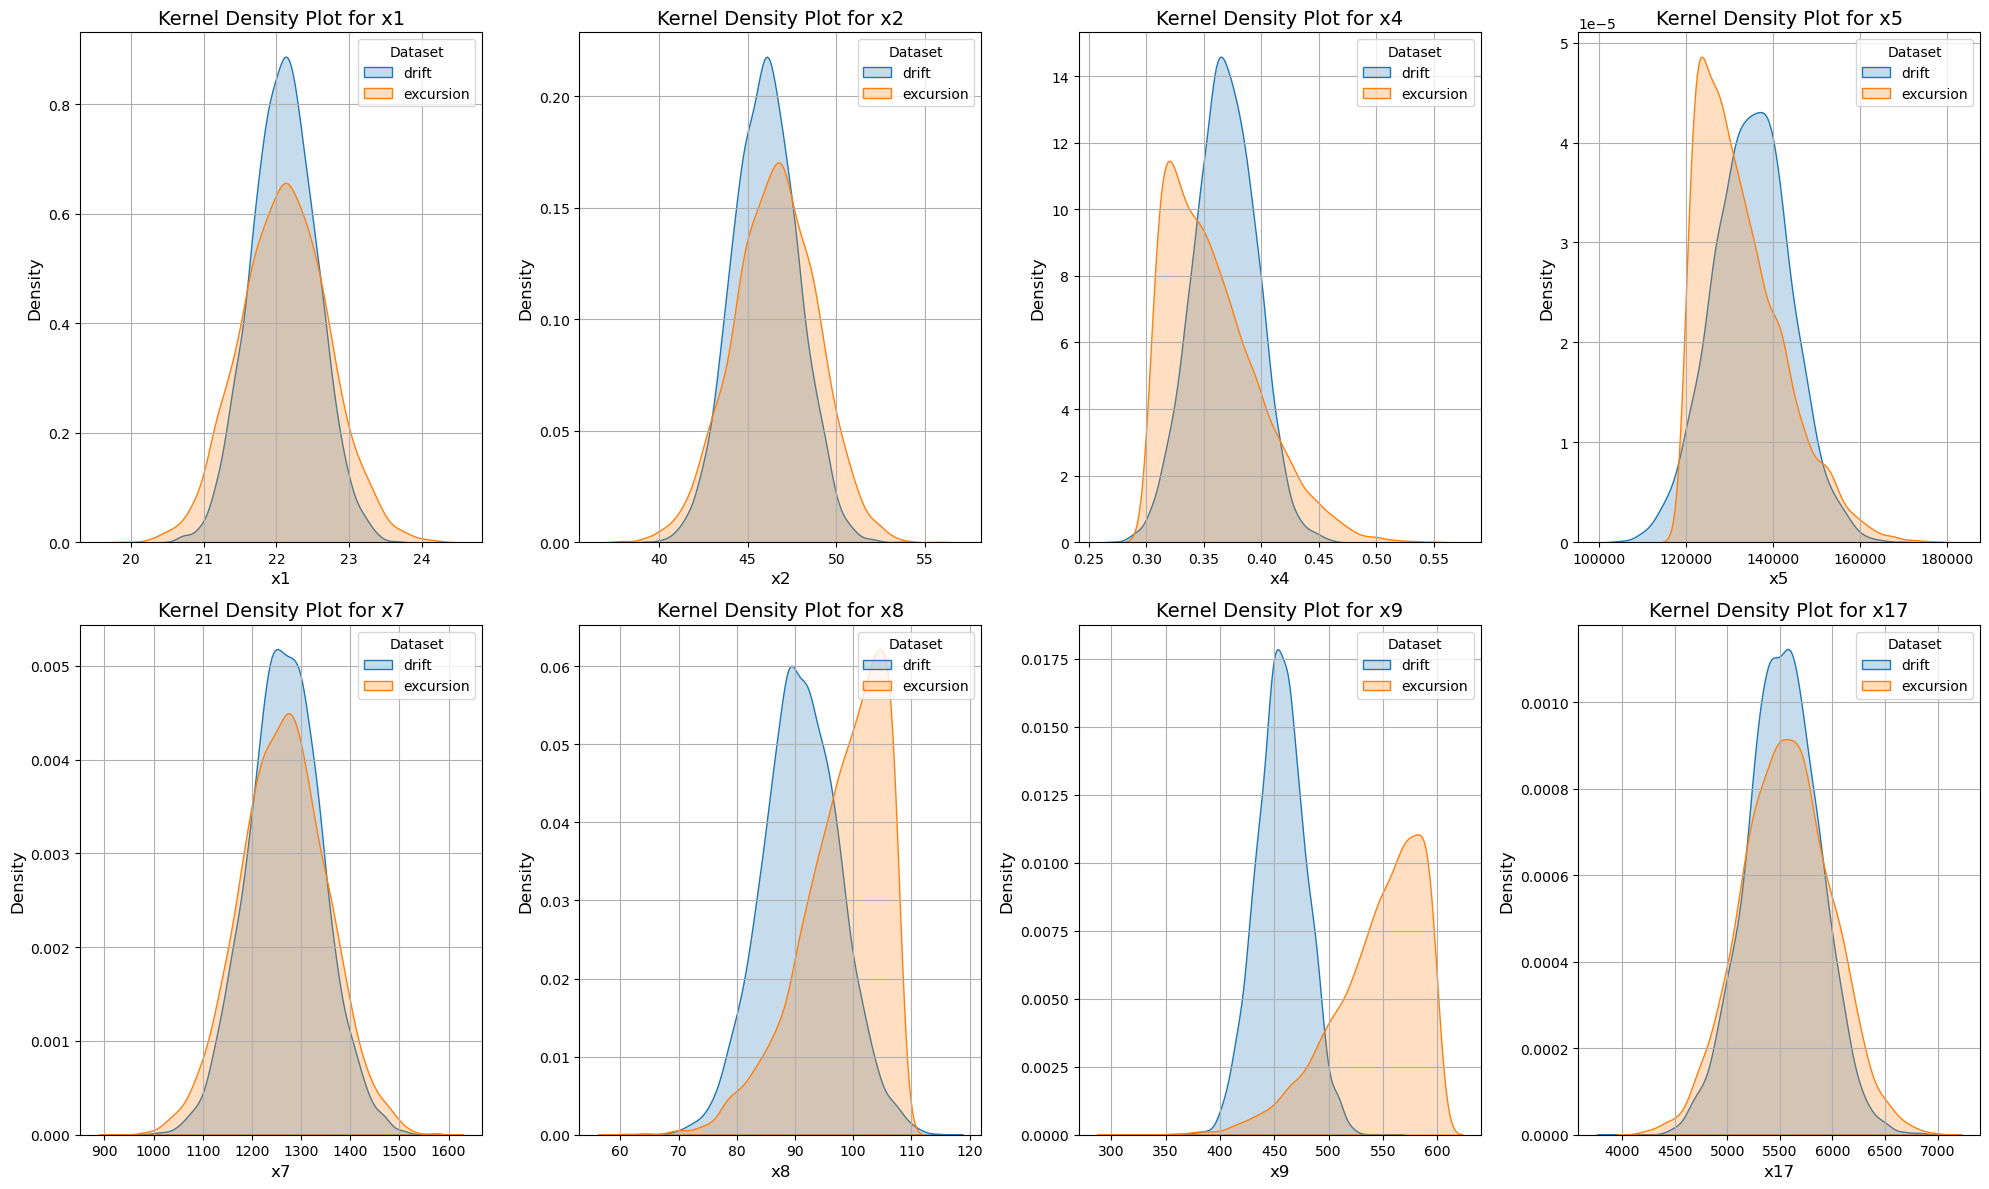

In [11]:
selected_variables = ['x1', 'x2', 'x4', 'x5', 'x7', 'x8', 'x9', 'x17']

plots_per_row = 4
num_variables = len(selected_variables)
num_rows = (num_variables + plots_per_row - 1) // plots_per_row 

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, 6 * num_rows))
axes = axes.flatten()  

# Generate the plots for the selected variables
for i, variable in enumerate(selected_variables):
    ax = axes[i]
    for name, df in datasets.items():
        sns.kdeplot(df[variable], label=name, fill=True, ax=ax)
    ax.set_title(f'Kernel Density Plot for {variable}', fontsize=14)
    ax.set_xlabel(variable, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(title='Dataset')
    ax.grid(True)

# Remove excess subplots if needed
for j in range(len(selected_variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Variables `x1`, `x2`, `x7`, and `x17` follow a normal distribution across both datasets.

- Variables `x4`, `x5`, `x8`, and `x9` exhibit skewed distributions in the excursion dataset.

This verifies that our synthetic data generation was performed correctly and reflects realistic conditions for further analysis.

### b. Kernel Density of Outcome Variable across Datasets

Next, we visualize the outcome variable across both datasets:

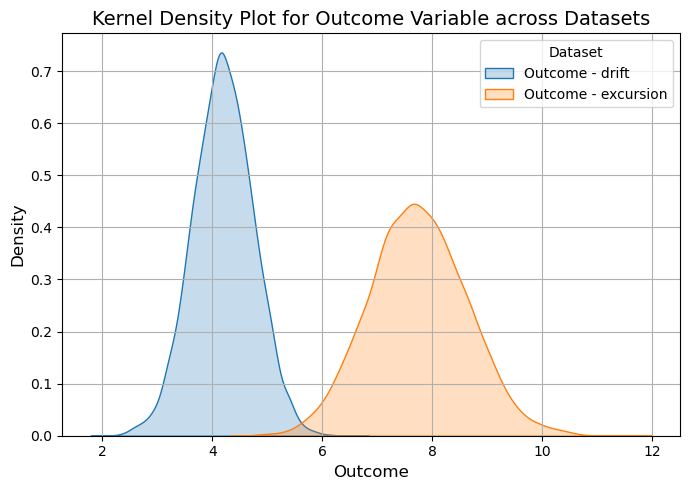

In [12]:
plt.figure(figsize=(7, 5))

# Loop over the datasets and plot the KDE for the 'outcome' variable in each
for name, df in datasets.items():
    sns.kdeplot(df['outcome'], label=f'Outcome - {name}', fill=True)

# Add labels and title
plt.title('Kernel Density Plot for Outcome Variable across Datasets', fontsize=14)
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Dataset')
plt.grid(True)

plt.tight_layout()
plt.show()

The **excursion dataset** shows a further drift along the outcome variable compared to the **drift dataset**, reflecting the expected behavior under extreme conditions.

### c. Correlation Between Variables in Drift Dataset

We analyze the correlation matrix of the drift dataset to identify relationships between variables:

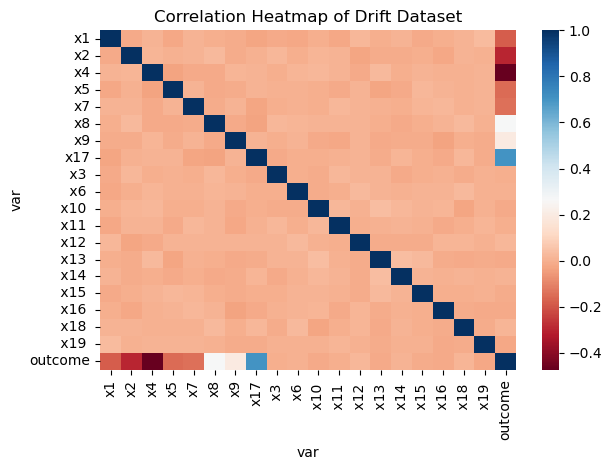

In [13]:
corr = drift_data.corr()

sns.heatmap(corr, 
            cmap='RdBu', 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Heatmap of Drift Dataset')
plt.tight_layout()
plt.show()

### d. Heatmap of Binned Interaction Between X5 and X9 on Outcome

To better understand the interaction between `x5` and `x9` and their combined effect on the outcome, we create a 2D heatmap by binning both variables:

C:\Users\hrith\AppData\Local\Temp\ipykernel_12420\2279498229.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  interaction_table_binned = drift_data_cleaned.pivot_table(


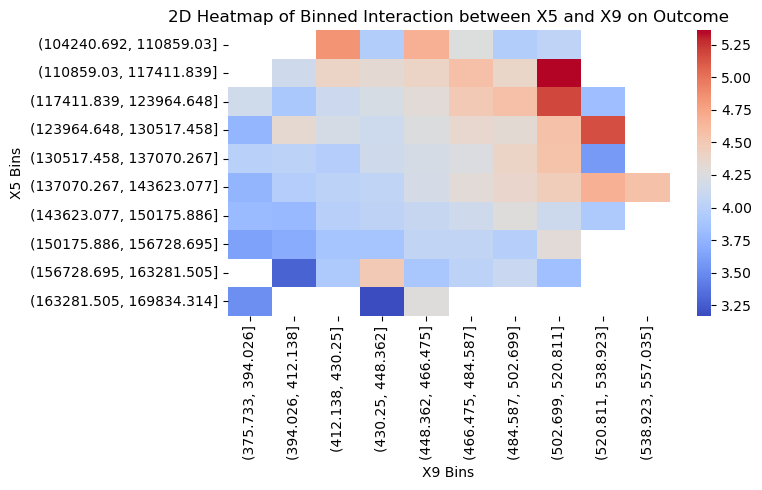

In [14]:
# Cleaning dataset by removing NaNs
drift_data_cleaned = drift_data.dropna(subset=['x5', 'x9', 'outcome'])

# Binning x5 and x9 into 10 bins each
drift_data_cleaned['x5_bins'] = pd.cut(drift_data_cleaned['x5'], bins=10)
drift_data_cleaned['x9_bins'] = pd.cut(drift_data_cleaned['x9'], bins=10)

# Creating a pivot table for binned interaction
interaction_table_binned = drift_data_cleaned.pivot_table(
    values='outcome', 
    index='x5_bins', 
    columns='x9_bins', 
    aggfunc='mean'
)

# Plotting the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(interaction_table_binned, cmap="coolwarm", annot=False)
plt.title("2D Heatmap of Binned Interaction between X5 and X9 on Outcome")
plt.xlabel("X9 Bins")
plt.ylabel("X5 Bins")
plt.tight_layout()
plt.show()

# 7.  Next Steps: Machine Learning Model Development

Following the synthetic data generation and exploratory data analysis, the next phase involves:

1. Building Machine Learning models based on the drift dataset.

2. Experimenting with different model architectures and hyperparameters.

3. Analyzing feature importance to identify key contributors to the outcome.

4. Using the trained model to predict and simulate outcomes for the excursion dataset.

This approach will help us assess how well the model generalizes under extreme conditions and provides actionable insights for further optimization.